## Exploracion de datos

In [22]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import pandas as pd
from PIL import Image
import numpy as np

import seaborn as sns

data_dir = './lung_dataset'

In [2]:
# Contar imágenes por clase
counts = {}
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        image_count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        counts[class_name] = image_count

# Mostrar resumen
for k, v in sorted(counts.items()):
    print(f"{k}: {v} imágenes")

lung_aca: 5000 imágenes
lung_n: 5000 imágenes
lung_scc: 5000 imágenes


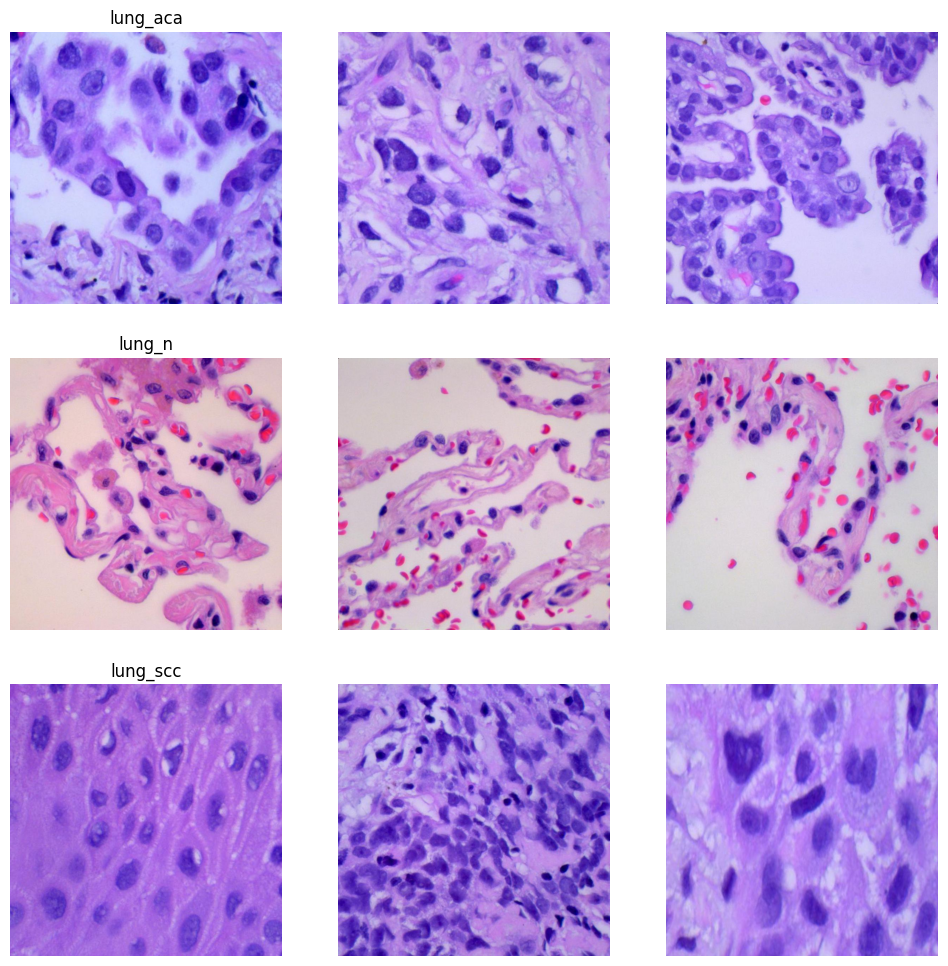

In [4]:
# Mostrar ejemplos por clase

n = 3
fig, axes = plt.subplots(len(counts), n, figsize=(n*4, len(counts)*4))

for i, class_name in enumerate(sorted(counts.keys())):
    class_path = os.path.join(data_dir, class_name)
    images = random.sample(os.listdir(class_path), n)
    
    for j, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = mpimg.imread(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if j == 0:
            axes[i, j].set_title(class_name, fontsize=12)

In [7]:
# Mapeo manual de clases a tipo y subtipo
class_info = {
    "lung_n":    {"Tipo": "Benigno", "Subtipo": "Tejido normal"},
    "lung_aca":  {"Tipo": "Maligno", "Subtipo": "Adenocarcinoma"},
    "lung_scc":  {"Tipo": "Maligno", "Subtipo": "Carcinoma escamoso"},
}

# Armar DataFrame
rows = []
for class_name, count in counts.items():
    tipo = class_info[class_name]["Tipo"]
    subtipo = class_info[class_name]["Subtipo"]
    rows.append({
        "Clase": class_name,
        "Tipo": tipo,
        "Subtipo": subtipo,
        "Nº de imágenes": count
    })

df_summary = pd.DataFrame(rows)
df_summary = df_summary.sort_values(by="Clase")
df_summary.reset_index(drop=True, inplace=True)
df_summary

Clase     Tipo             Subtipo  Nº de imágenes
0  lung_aca  Maligno      Adenocarcinoma            5000
1    lung_n  Benigno       Tejido normal            5000
2  lung_scc  Maligno  Carcinoma escamoso            5000

## Analizar resolución y propiedades de las imágenes

In [10]:
# Recopilar tamaños
image_sizes = []

for class_name in sorted(counts.keys()):
    class_path = os.path.join(data_dir, class_name)
    filenames = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    for fname in filenames[:300]:  # Muestra limitada para análisis rápido
        path = os.path.join(class_path, fname)
        with Image.open(path) as img:
            width, height = img.size
            image_sizes.append({"Clase": class_name, "Ancho": width, "Alto": height})

# Convertir a DataFrame
df_sizes = pd.DataFrame(image_sizes)
df_sizes.head()

Clase  Ancho  Alto
0  lung_aca    768   768
1  lung_aca    768   768
2  lung_aca    768   768
3  lung_aca    768   768
4  lung_aca    768   768

## Crear el DataLoader

In [18]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch

In [ ]:
# Transformaciones sugeridas para RestNet

transform = transforms.Compose([
    transforms.Resize((224, 224)),               
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [23]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes

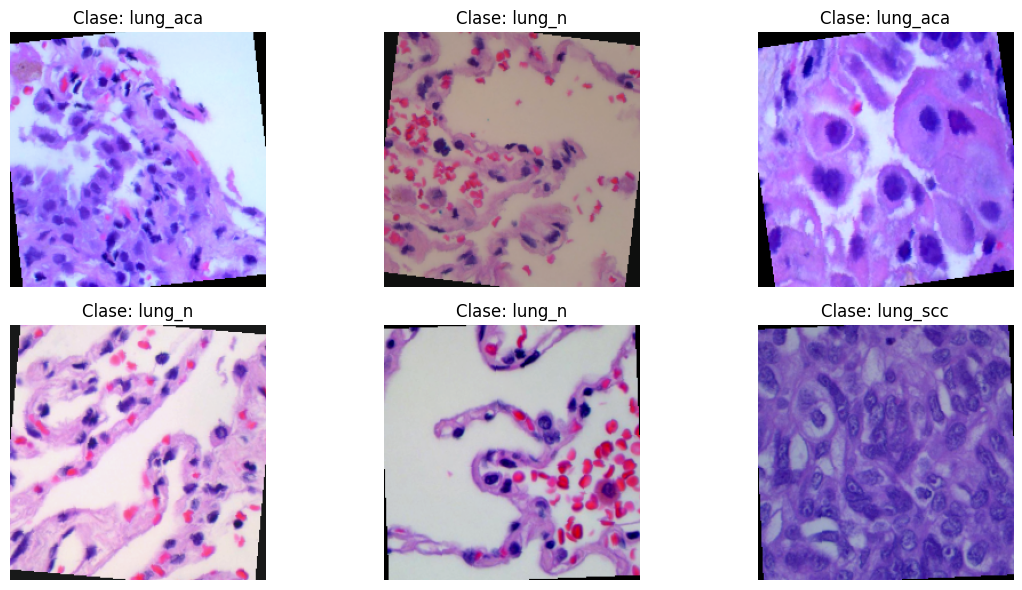

In [24]:
def imshow_tensor(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]
    img = std * img + mean  # desnormalizar
    img = np.clip(img, 0, 1)
    plt.imshow(img)

# Visualizar algunas muestras
loader = DataLoader(dataset, batch_size=6, shuffle=True)
images, labels = next(iter(loader))

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    imshow_tensor(images[i])
    plt.title(f"Clase: {class_names[labels[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

## Separar el dataset en entrenamiento y validación

In [25]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

## Preparar el modelo



In [ ]:
import torch.nn as nn

class ResNetLung(nn.Module):
    def __init__(self, block, num_blocks, num_classes=3):  # ← 3 clases
        super(ResNetLung, self).__init__()
        self.in_channels = 64  # Empezamos con 64 canales
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, 2)
        self.layer2 = self._make_layer(block, 128, 2, stride=2)
        self.layer3 = self._make_layer(block, 256, 2, stride=2)
        self.layer4 = self._make_layer(block, 512, 2, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [30]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Proyección si cambian dimensiones o stride
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = self.relu(out)
        return out

## Entrenar el modelo

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim

if torch.backends.mps.is_available(): # Uso Mac
    device = torch.device("mps")
    print("Usando Metal (MPS)")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Usando dispositivo: {device}")

model = ResNetLung(ResidualBlock, [2, 2, 2, 2], num_classes=3).to(device)

# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Usando Metal (MPS)


In [32]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Modo entrenamiento
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Reiniciar gradientes
        optimizer.zero_grad()

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        # Estadísticas
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"📚 Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

📚 Epoch [1/10], Loss: 0.3668, Accuracy: 85.62%
📚 Epoch [2/10], Loss: 0.2530, Accuracy: 89.48%
📚 Epoch [3/10], Loss: 0.1953, Accuracy: 91.87%
📚 Epoch [4/10], Loss: 0.1860, Accuracy: 92.57%
📚 Epoch [5/10], Loss: 0.1841, Accuracy: 92.73%
📚 Epoch [6/10], Loss: 0.1511, Accuracy: 94.03%
📚 Epoch [7/10], Loss: 0.1383, Accuracy: 94.25%
📚 Epoch [8/10], Loss: 0.1284, Accuracy: 94.93%
📚 Epoch [9/10], Loss: 0.1269, Accuracy: 94.89%
📚 Epoch [10/10], Loss: 0.1136, Accuracy: 95.61%


In [48]:
# Transformación (ya la tienes definida, úsala si ya existe)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Carga del dataset completo
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Acceder a los nombres de clases
class_names = full_dataset.classes

# División en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

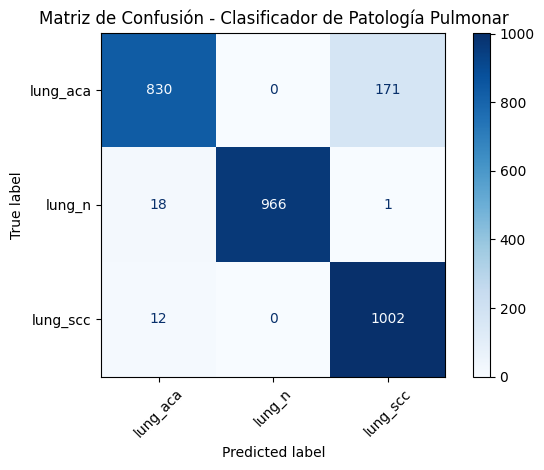

In [36]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Asegúrate de que el modelo esté en modo evaluación
model.eval()

# Listas para almacenar etiquetas reales y predichas
all_preds = []
all_labels = []

# Sin gradientes
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcular la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matriz de Confusión - Clasificador de Patología Pulmonar")
plt.tight_layout()
plt.show()

In [37]:
torch.save(model.state_dict(), "resnet_lung_weights.pth")

In [38]:
model.eval()
dummy_input = torch.randn(1, 3, 224, 224).to(device)
traced_model = torch.jit.trace(model, dummy_input)
traced_model.save("resnet_lung_model.pt")

In [44]:
model = ResNetLung(ResidualBlock, [2, 2, 2, 2], num_classes=3)
model.load_state_dict(torch.load("resnet_lung_weights.pth", map_location=device))
model = model.to(device)
model.eval()



ResNetLung(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [45]:

# Obtener un lote de prueba
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Realizar predicciones
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

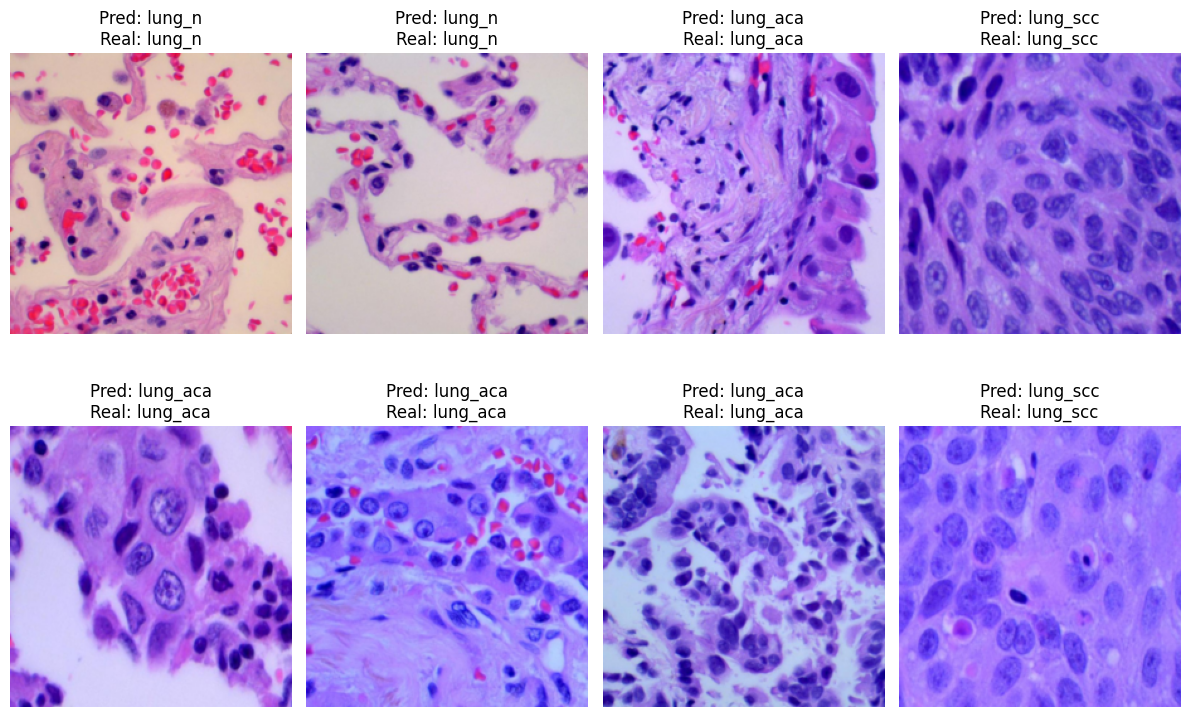

In [50]:
import matplotlib.pyplot as plt
import torch

# Tomar un batch del test_loader
images, labels = next(iter(test_loader))

# Mover imágenes al dispositivo adecuado
images = images.to(device)

# Hacer predicciones (modelo en modo evaluación y sin gradientes)
model.eval()
with torch.no_grad():
    preds = model(images)

# Obtener clase predicha
preds = torch.argmax(preds, dim=1)

# Volver todo a CPU para graficar
images = images.cpu()
preds = preds.cpu()
labels = labels.cpu()

# Obtener los nombres de clase
class_names = test_loader.dataset.dataset.classes  # porque es un Subset

# Mostrar grilla
plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    img = images[i].permute(1, 2, 0)
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = img.clip(0, 1)
    plt.imshow(img)
    plt.title(f"Pred: {class_names[preds[i]]}\nReal: {class_names[labels[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()